In [1]:
# Strategy Overview
# Renko Box Size:
# Calculated using the ATR (14) of the previous day’s 5-minute candles.
# Rounded to the nearest 10 paisa for each stock.
# Indicators Used:
# Renko Charts for price filtering.
# EMA (Exponential Moving Average) applied to Renko closing prices instead of candlestick data.
# Trading Hours:
# The algorithm starts scanning for trades at 9:20 AM to allow for initial market stabilization.
# Uses the first 5-minute candle (9:15 - 9:20 AM) for calculations.
# Profit/Loss Tracking:
# A separate P&L tracker is maintained for each stock to monitor individual performance.
# Trading for a specific stock stops once the profit or loss reaches $10 for the day.
# 2. Entry Rules
# Buy: When the Renko closing price is greater than the EMA.
# Sell: When the Renko closing price is less than the EMA.
# Note: The EMA calculation must be based on Renko box closing prices, not candlestick data.
# 3. Exit Rules
# Stop Loss (SL):
# 2 Renko bricks (e.g., if the box size is $1.5, SL = $3).
# Take Profit (TP):
# Square off 50% of the position at 2 Renko bricks profit.
# Trail the remaining position until a Renko box reversal (opposite-direction brick forms).
# Trade Limits:
# Maximum 2 trades per stock per day.
# Stop trading a stock once its profit or loss reaches ₹1,000 for the day (tracked only after closing the position).


import pandas as pd
import numpy as np
import datetime
import pendulum as dt
from ib_async import *
util.startLoop()  # uncomment this line when in a notebook
import time
import logging

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf


strategy_name='renko_ema'

logging.basicConfig(level=logging.INFO, filename=f"{strategy_name}.log",filemode='a',format="%(asctime)s - %(message)s")
logging.getLogger('ib_async').setLevel(logging.CRITICAL)

def calculate_ema(prices, period):
    """
    Calculate the Exponential Moving Average (EMA) of a list of prices.
    
    :param prices: List of floats or ints (e.g., daily closing prices)
    :param period: Integer - the period for the EMA (e.g., 10, 20, 50)
    :return: List of EMA values (same length as prices, with None for first period-1 values)
    """
    if len(prices) < period:
        return [None] * len(prices)

    ema_values = [None] * (period - 1)  # EMA not defined for the first 'period - 1' values
    sma = sum(prices[:period]) / period
    ema_values.append(sma)

    multiplier = 2 / (period + 1)
    
    for price in prices[period:]:
        ema_prev = ema_values[-1]
        ema_current = (price - ema_prev) * multiplier + ema_prev
        ema_values.append(ema_current)

    return ema_values

print('strategy started')
logging.info('strategy started')


ib = IB()
ib.connect('127.0.0.1', 7497, clientId=2)


time_zone='America/New_York'
tickers = ['TSLA','NVDA','GOOG','AMZN','AAPL','META','NFLX','MSFT','LNTH','AMD']
exchange='SMART'
currency='USD'
account_no='DUH316001'
ord_validity='GTC'
quantity_=1
#start time
start_hour,start_min=8,52
#end time
end_hour,end_min=15,0

contract_objects={}
for ticker in tickers:
    c=ib.qualifyContracts(Stock(ticker,exchange, currency))[0]
    # print(c)
    contract_objects.update({ticker:c})
print(contract_objects)

def get_historical_data(contract,duration='3 D',candle='5 mins'):

    bars = ib.reqHistoricalData(
        contract, endDateTime=dt.now(time_zone), durationStr=duration,
        barSizeSetting=candle, whatToShow='TRADES', useRTH=True)
    # convert to pandas dataframe (pandas needs to be installed):
    df = util.df(bars)

    df.set_index('date', inplace=True)
    return df


def candle_renko_refresh(ticker,brick_size,data):
    print('candle_renko_refresh')
    calculated_values = {}
    # matplotlib.use('Agg')  # Use a non-interactive backend
    mpf.plot(data, type='renko', renko_params=dict(brick_size=brick_size),return_calculated_values=calculated_values,returnfig=False,style='yahoo')
    plt.show()
    # plt.close()
    renko_df = pd.DataFrame(calculated_values)
    print(renko_df)

    def count_bricks(sign_list):
        list1=[]
        pos_count=0
        neg_count=0
        for k in range(len(sign_list)):
            i=sign_list[k]
            if i>0:
                if sign_list[k-1]<0:
                    pos_count=1
                    list1.append(pos_count)
                else:
                    pos_count+=1
                    list1.append(pos_count)

            elif i<0:
                if sign_list[k-1]>0:
                    neg_count=-1
                    list1.append(neg_count)
                else:
                    neg_count-=1
                    list1.append(neg_count)
            else:
                list1.append(0)
        return list1


    renko_df.drop(columns=['renko_volumes','minx','maxx','miny','maxy'],inplace=True,axis=1)

    renko_df['pos_count']=count_bricks(renko_df['renko_bricks'].diff().tolist())



    high=[0]
    low=[0]
    open=[0]
    close=[0]
    #go through renko_bricks and pos_count columns
    for renko,pos in zip(renko_df['renko_bricks'],renko_df['pos_count']):


        if pos<0:
            open.append(renko)
            high.append(renko)
            close.append(renko-brick_size)
            low.append(renko-brick_size)

        elif pos>0:
            close.append(renko)
            high.append(renko)
            open.append(renko-brick_size)
            low.append(renko-brick_size)

    renko_df['OPEN'] = open
    renko_df['HIGH'] = high
    renko_df['LOW'] = low
    renko_df['CLOSE'] = close

    # calculate donchain channel
    renko_df.set_index('renko_dates',inplace=True)
    print(renko_df)
   
    # renko_df['ema'] = d
    # #filter data for current date
    # renko_df=renko_df[renko_df.index.date==dt.now(time_zone).date()]
    # return renko_df


contract=contract_objects['NVDA']
data=get_historical_data(contract,duration='1 M',candle='1 min')
# data=get_historical_data(contract,duration='1 Y',candle='1 day')
print(data)


strategy started
{'TSLA': Stock(conId=76792991, symbol='TSLA', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TSLA', tradingClass='NMS'), 'NVDA': Stock(conId=4815747, symbol='NVDA', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='NVDA', tradingClass='NMS'), 'GOOG': Stock(conId=208813720, symbol='GOOG', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='GOOG', tradingClass='NMS'), 'AMZN': Stock(conId=3691937, symbol='AMZN', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='AMZN', tradingClass='NMS'), 'AAPL': Stock(conId=265598, symbol='AAPL', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='AAPL', tradingClass='NMS'), 'META': Stock(conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS'), 'NFLX': Stock(conId=15124833, symbol='NFLX', exchange='SMART', primaryExchange='NASDAQ', currency='USD', loc

In [4]:
data=get_historical_data(contract,duration='1 Y',candle='1 day')
data

,open,high,low,close,volume,average,barCount
date,,,,,,,
2024-06-12,123.05,126.88,122.57,125.20,224668029.0,125.265,627206
2024-06-13,129.39,129.80,127.16,129.61,193268816.0,128.767,552120
2024-06-14,129.96,132.84,128.32,131.88,238270147.0,131.203,669597
2024-06-17,132.93,133.73,129.58,130.98,213768169.0,131.750,653433
2024-06-18,131.14,136.33,130.69,135.58,230334735.0,134.269,659454
...,...,...,...,...,...,...,...
2025-06-05,142.15,144.00,138.83,139.99,157398801.0,141.610,572921
2025-06-06,142.51,143.27,141.51,141.72,110234161.0,142.243,422090
2025-06-09,143.21,145.00,141.95,142.63,133169356.0,143.289,489741


In [14]:
data1=data.reset_index()
import pandas as pd
data1['date']=pd.to_datetime(data1['date'])
data1['date']=data1['date'] + pd.to_timedelta('15:30:00')
data1=data1.set_index('date')
data1

,open,high,low,close,volume,average,barCount
date,,,,,,,
2024-06-12 15:30:00,123.05,126.88,122.57,125.20,224668029.0,125.265,627206
2024-06-13 15:30:00,129.39,129.80,127.16,129.61,193268816.0,128.767,552120
2024-06-14 15:30:00,129.96,132.84,128.32,131.88,238270147.0,131.203,669597
2024-06-17 15:30:00,132.93,133.73,129.58,130.98,213768169.0,131.750,653433
2024-06-18 15:30:00,131.14,136.33,130.69,135.58,230334735.0,134.269,659454
...,...,...,...,...,...,...,...
2025-06-05 15:30:00,142.15,144.00,138.83,139.99,157398801.0,141.610,572921
2025-06-06 15:30:00,142.51,143.27,141.51,141.72,110234161.0,142.243,422090
2025-06-09 15:30:00,143.21,145.00,141.95,142.63,133169356.0,143.289,489741


In [2]:
data

,open,high,low,close,volume,average,barCount
date,,,,,,,
2025-05-13 09:30:00-04:00,124.98,125.00,124.62,124.72,4556549.0,124.920,6574
2025-05-13 09:31:00-04:00,124.73,125.50,124.47,125.43,2442072.0,125.053,8556
2025-05-13 09:32:00-04:00,125.44,125.76,125.00,125.52,2098477.0,125.408,8365
2025-05-13 09:33:00-04:00,125.53,125.80,125.35,125.79,1180061.0,125.629,4814
2025-05-13 09:34:00-04:00,125.80,125.85,125.55,125.64,1306267.0,125.682,5496
...,...,...,...,...,...,...,...
2025-06-11 15:55:00-04:00,142.87,143.00,142.77,142.79,673284.0,142.888,3608
2025-06-11 15:56:00-04:00,142.79,142.84,142.75,142.77,378472.0,142.788,1943
2025-06-11 15:57:00-04:00,142.76,142.84,142.69,142.78,565084.0,142.755,2703


candle_renko_refresh


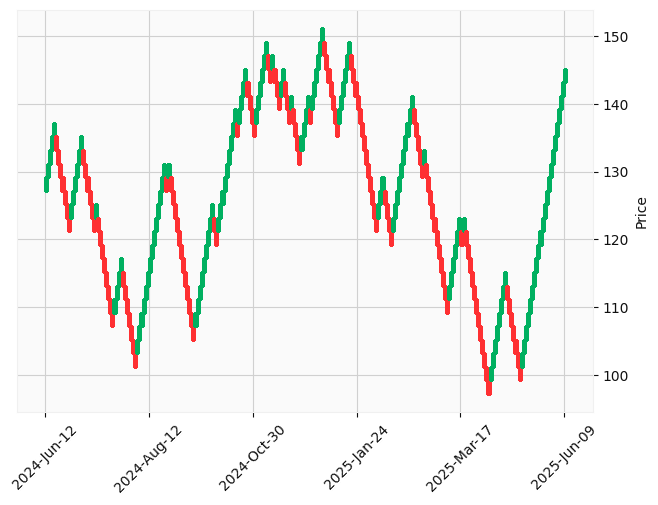

     renko_bricks               renko_dates  renko_size renko_volumes  \
0           127.2 2024-06-12 15:30:00+00:00           2          None   
1           129.2 2024-06-12 15:30:00+00:00           2          None   
2           131.2 2024-06-13 15:30:00+00:00           2          None   
3           133.2 2024-06-17 15:30:00+00:00           2          None   
4           135.2 2024-06-17 15:30:00+00:00           2          None   
..            ...                       ...         ...           ...   
246         135.2 2025-05-13 15:30:00+00:00           2          None   
247         137.2 2025-05-28 15:30:00+00:00           2          None   
248         139.2 2025-06-02 15:30:00+00:00           2          None   
249         141.2 2025-06-02 15:30:00+00:00           2          None   
250         143.2 2025-06-09 15:30:00+00:00           2          None   

         minx        maxx  miny   maxy  
0   -0.996016  250.996016  97.2  151.2  
1   -0.996016  250.996016  97.2  151.2  


In [15]:

candle_renko_refresh('TSLA',2,data1)

In [16]:
data=get_historical_data(contract,duration='6 M',candle='5 mins')
data

,open,high,low,close,volume,average,barCount
date,,,,,,,
2024-12-16 09:30:00-05:00,134.17,134.40,132.31,132.73,9438105.0,133.438,28037
2024-12-16 09:35:00-05:00,132.70,133.07,130.45,131.11,8817062.0,131.363,32609
2024-12-16 09:40:00-05:00,131.14,132.32,131.11,131.35,5981061.0,131.792,21747
2024-12-16 09:45:00-05:00,131.37,132.00,130.92,131.89,4130021.0,131.452,15906
2024-12-16 09:50:00-05:00,131.88,132.76,131.50,132.70,4454040.0,132.207,15147
...,...,...,...,...,...,...,...
2025-06-11 15:35:00-04:00,142.36,142.69,142.29,142.61,1042851.0,142.495,3867
2025-06-11 15:40:00-04:00,142.62,142.81,142.56,142.73,1325709.0,142.704,4936
2025-06-11 15:45:00-04:00,142.73,142.95,142.67,142.71,1290348.0,142.811,5210
